#EECS 504 PS3: Motion Magnification and Texture Synthesis

Please provide the following information 
(e.g. Andrew Owens, ahowens):

Nidhi Sridhar, nidhisri




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the notebook to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import math
import scipy.ndimage # For image filtering

import random
import sys
from scipy import ndimage

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

In [0]:
%%capture
# download some images
# should take a second to run

# for motion magnification problem
! wget -O bill.avi "https://drive.google.com/uc?export=download&id=1QR2dCShn-fYYEvcAQ8J4mnIo_ISqrjc7"

# for texture synthesis problem
! wget -O texture.jpg "https://drive.google.com/uc?export=download&id=11IlTZNLwfYsXQt2L1GbKdNqcj6JNkQik"
! wget -O rings.jpg "https://drive.google.com/uc?export=download&id=1fYtmQe_a40BWg1OU178SFbcU4KRZuphn"
! wget -O my_image.jpg "https://blenderartists.org/uploads/default/original/4X/7/b/1/7b192d17acd5342a4e7ae6ae76bb9b9bd2b681f7.png"
! wget -O jigsaw.jpg "https://drive.google.com/uc?export=download&id=1SlYUw6vT9_PNP8XNhQfAu36AtPJ-PMpk"

## **Problem 3.1 (a)**

In [0]:
def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

In [0]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4;

# horizontal movement from (0, 0) to (0, 1)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1

ff1 = fftshift(fft2(im1))
ff2 = fftshift(fft2(im2))

### This is a quick tutorial for those who are not familiar with complex numbers in python.

In [47]:
# create a complex number
x = 1 + 1j
print("x =", x)
print("x.real", x.real, "x.imag", x.imag)

# magnitude and phase of complex number
mag = abs(x)
phase = angle(x)

print("Magnitude", mag)
print("Phase", phase)

# Euler's formula
y = mag * exp(phase * 1j)
print("y =", y)

x = (1+1j)
x.real 1.0 x.imag 1.0
Magnitude 1.4142135623730951
Phase 0.7853981633974483
y = (1.0000000000000002+1j)


In [0]:
def magnify_change(im1, im2, magnification_factor):
    
    # find phase shift in frequency domain
    im1_dft = fft2(im1)
    im2_dft = fft2(im2)
    phase_shift = angle(im2_dft) - angle(im1_dft)
    
    # magnify the phase change in frequency domain 
    magnified_dft = abs(im1_dft) * exp((magnification_factor*phase_shift + angle(im1_dft)) * 1j)
    #magnified_dft = magnification_factor*phase_shift*1j
    
    # what does the magnified phase change cause in image space?
    magnified = ifft2(magnified_dft).real
    
    return magnified

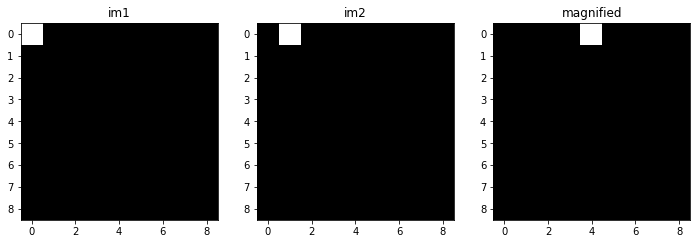

In [49]:
# magnify position change
magnified = magnify_change(im1, im2, magnification_factor);

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

## **Problem 3.1 (b)**


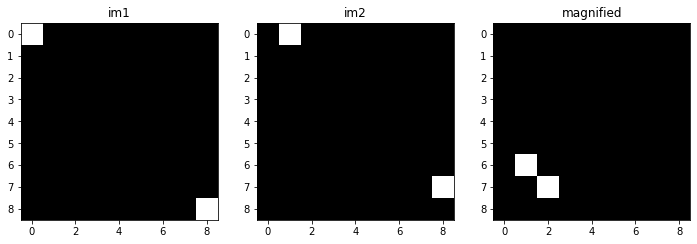

In [50]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# magnify position change
magnified = magnify_change(im1, im2, magnification_factor)


plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');


3.1b) The two offsets were not properly magnified, because for this method to produce accurate results, we require that the movement of one pixel in a particular direction should not affect the movement (magnified) that has already taken place in the other image. This method would only work if angle i.e. phase was a linear operation. As this is not the case, we see that both pixels get magnified up and to the right, giving us the final magnified output where both pixels have wrapped around as shown

## **Problem 3.1 (c)**


Text(0.5, 1.0, 'magnified')

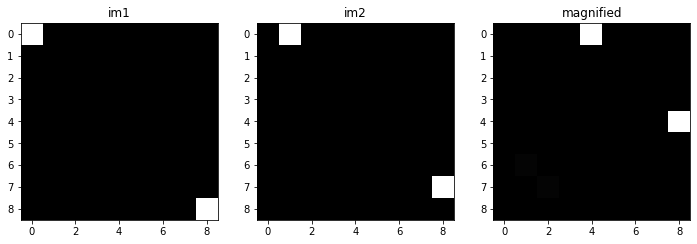

In [51]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# width of our Gaussian window
sigma = 2

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# we will magnify windows of the image and aggregate the results
magnified = np.zeros([im_size, im_size])

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(im_size), np.arange(im_size))

for y in range(0, im_size, 2*sigma):
    for x in range(0, im_size, 2*sigma):
        gaussian_mask = exp(-((X-x)**2+(Y-y)**2)/(2*sigma**2))
        window_magnified = magnify_change(gaussian_mask*im1, gaussian_mask*im2,
                                          magnification_factor)
        
        magnified = magnified + window_magnified
        
plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified')

## **Problem 3.1 (d) - Motion Magnification**


In [52]:
import numpy as np
import cv2

cap = cv2.VideoCapture('bill.avi')

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()
    
    if ret is False:
        break

    frame = cv2.resize(frame, (200, 200), interpolation=cv2.INTER_CUBIC)
    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames) / 255.
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
num_frames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

frames size: (60, 200, 200, 3) # (nb_frames, height, width, channel)


In [53]:
# 10x magnification of motion
magnification_factor = 10

# width of Gaussian window
sigma = 26

# alpha for moving average
alpha = 0.5

# we will magnify windows of the video and aggregate the results
magnified = np.zeros_like(frames)

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(width), np.arange(height))

# iterate over windows of the frames
x_range = list(range(0, width, 2*sigma))
y_range = list(range(0, height, 2*sigma))
num_windows = len(x_range) * len(y_range)
window_index = 1

for y in y_range:
    for x in x_range:
        for channel_index in range(3): # RGB channels
            for frame_index in range(num_frames):
                
                # create windowed frames
                gaussian_mask = (1/(2*np.pi*sigma**2))*exp(-((X-x)**2+(Y-y)**2)/(2*sigma**2))
                windowed_frames = gaussian_mask * frames[frame_index,:,:,channel_index]
            
                # initialize moving average of phase for current window/channel
                if frame_index == 0:
                    window_average_phase = angle(fft2(windowed_frames))
                
                window_dft = fft2(windowed_frames)
                
                # compute phase shift and constrain to [-pi, pi] since
                # angle space wraps around
                window_phase_shift = angle(window_dft) - window_average_phase
                window_phase_shift[window_phase_shift > pi] = window_phase_shift[window_phase_shift > pi] - 2 * pi
                window_phase_shift[window_phase_shift < -pi] = window_phase_shift[window_phase_shift < -pi] + 2 * pi
                
                # magnify phase shift
                window_magnified_phase = magnification_factor*window_phase_shift
                 
                # go back to image space
                window_magnified_dft = abs(window_dft)*exp((window_average_phase + window_magnified_phase)*1j )
                window_magnified = abs(ifft2(window_magnified_dft))
                
                # update moving average
                window_phase_unwrapped = window_average_phase + window_phase_shift
                window_average_phase = alpha * window_average_phase + (1 - alpha) * window_phase_unwrapped
                
                # aggregate
                magnified[frame_index,:,:,channel_index] = magnified[frame_index,:,:,channel_index] + window_magnified
        
        # print progress
        print('{}/{}'.format(window_index, num_windows))
        window_index += 1

1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
16/16


In [0]:
outputs = magnified / np.max(magnified)
for channel_index in range(3):
    original_frame = frames[0,:,:,channel_index]
    magnified_frame = outputs[0,:,:,channel_index]
    scale = np.std(original_frame[:]) / np.std(magnified_frame[:])
    original_mean = np.mean(original_frame[:])
    magnified_mean = np.mean(magnified_frame[:])
    outputs[:,:,:,channel_index] = magnified_mean + scale * (outputs[:,:,:,channel_index] - magnified_mean)

outputs = np.clip(outputs, 0, 1)

In [0]:
# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnified.avi',fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(outputs[i], 0, 1) * 255).astype(np.uint8)
    
    # write frame to output video
    out.write(frame)

out.release()

In [0]:
# Only for colab downloading videos
try:
    from google.colab import files
    files.download('bill_magnified.avi')
except:
    print("Only for google colab")

## **Problem 3.2 - Texture Synthesis**

Note that the functions provided below are templates. Feel free to add your own helper functions as needed.

You can reference the pseudocode provided here:  https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html.

### Find matches function

In [0]:
#Final Find Matches
def find_matches(template, sample, gauss_mask):
    ### parameters, as used by Efros and Leung
    epsilon = 0.1
    delta = 0.3

    [sheight, swidth, channels] = sample.shape
    win_size = template.shape[0]
    w = win_size//2
    s = sheight - win_size + 1
    
    
    SSD = np.zeros((s*s))

    #### TODO:
    # valid_mask is a square mask of width window_size that is 1 where template is filled
    valid_mask = np.zeros((win_size, win_size))
    for i in range(win_size):
      for j in range(win_size):
        if template[i,j,0] !=0 or template[i,j,1] !=0 or template[i,j,2] !=0:
          valid_mask[i,j] = 1

    gaussian_m = np.multiply(gauss_mask, valid_mask.astype(np.float64))
    mask = gaussian_m.reshape(win_size*win_size, 1) / np.sum(gaussian_m)

    """for i in range(template.shape[0]):
      for j in range(template.shape[1]):
        for ii in range(w):
          for jj in range(w):"""
    

    #### TODO:
    # vectorized code that calculates SSD(template, sample)*mask for all patches
    template = template.reshape(win_size*win_size, 1, channels)
    
    stride_shape = win_size, win_size, s, s, channels
    s0, s1, s2 = sample.strides
    strides = s0, s1, s0, s1, s2
    
    sliding_win = np.lib.stride_tricks.as_strided(sample, shape=stride_shape, strides=strides)
    samp = sliding_win.reshape(win_size*win_size, s*s, channels)
    dist = (template - samp)**2
    SSD = np.sum(np.sum(dist, axis=2)*mask, axis=0)
    
    # Return best matches
    ssd_min = np.min(SSD)
    
    SSD = SSD.reshape(s,s)
    pixellist = np.where(SSD <= ssd_min*(1+epsilon))
            
    return sample[pixellist[0] + w, pixellist[1] + w], SSD[pixellist]

### Synthesize texture function

In [0]:
def synth_texture(sample, window_size, out_size):
    # normalize pixel intensity
    delta = 0.3
    delta_start_value = delta
    sample = sample.astype(np.float64)
    sample = sample / 255.0
    seed_size = 3
    [sheight, swidth, channels] = sample.shape
    synth_img = np.zeros((*out_size, channels))
    #synth_img = np.full((*out_size, channels), np.nan)

    # initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image
    rh = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    rw = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    #rw = 3
    #rh = 31
    center = [round(.5 * x) for x in out_size] # center
    #center = np.array([4,32])
    synth_img[center[0]: center[0] + seed_size, center[1]: center[1] + seed_size ,:] = sample[rh: rh + seed_size , rw: rw + seed_size,:]

    # bitmap indicating filled pixels, the seed patch is initially filled
    filled = np.zeros(out_size)
    filled[center[0]: center[0] + seed_size , center[1]: center[1] + seed_size] = 1
    num_filled = int(np.sum(filled))
    n_pixels = out_size[0]*out_size[1]

    # TODO
    # intialize 2D zero-mean gaussian w/ variance = (window_size / 6.4)
    sigma = window_size/6.4
    w = int(window_size/2)
    #G = np.zeros((window_size, window_size))
    #G[int(window_size/2), int(window_size/2)] = 1
    X, Y = np.meshgrid(np.arange(-w, w +1), np.arange(-w, w+1))
    #G[int(window_size/2), int(window_size/2)] = 1
    G = (1/(2*np.pi*sigma**2))*exp(-((X)**2+(Y)**2)/(2*sigma**2))
    G[int(window_size/2), int(window_size/2)] = 1


    """w = 5
sigma = w/6.4
#w = int(w/2)
G = np.zeros((w, w))
G[int(w/2), int(w/2)] = 1
X, Y = np.meshgrid(np.arange(-w, w +1), np.arange(-w, w+1))
G = (1/(2*np.pi*sigma**2))*exp(-((X)**2+(Y)**2)/(2*sigma**2))"""
    #plt.imshow(gaussian_mask)

    # main loop: repeat until all pixels are filled
    next_p = n_pixels / 10
    while(num_filled < n_pixels):
        # report progress
        if(num_filled > next_p):
            print(round(100 * num_filled / n_pixels), '% complete')
            next_p += n_pixels / 10

        # TODO:
        # get list of unfilled pixels as (x, y) coordinates
        # hint: use dilation and masking to efficiently find unfilled neighboring pixels
        unfilled = scipy.ndimage.binary_dilation(filled).astype(filled.dtype) - filled
        pixel_list = []
        for i in range(out_size[0]):
          for j in range(out_size[1]):
            if unfilled[i,j] != 0:
              pixel_list.append((i,j))
        #print(pixel_list)

        # TODO:
        # (optional, but recommended) randomly permute and sort list of pixels decreasing number of filled neighbor pixels

        # TODO:
        # iterate over the list of pixels
        w = window_size//2
        for x, y in pixel_list:
          #print(x, y)
          maxx = y + w + 1
          minx = y - w
          maxy = x + w + 1
          miny = x - w

          #synthimg indices
          s_maxx = min(maxx, out_size[0])
          s_minx = max(minx,    0)
          s_maxy = min(maxy, out_size[1])
          s_miny = max(miny,    0)

          #template indices
          t_maxx = window_size - (maxx - s_maxx)
          t_minx = 0 - (minx - s_minx)
          t_maxy = window_size - (maxy - s_maxy)
          t_miny = 0 - (miny - s_miny)

          # TODO:
          # place window with center as (x, y) and use as template
            
          template = np.zeros((window_size, window_size, channels))
          #template[x-w:x+w, y-w:y+w, :] = synth_img[x-w:x+w, y-w:y+w, :]
          #template = synth_img[x-w:x+w, y-w:y+w, :]
          template[t_miny : t_maxy, t_minx : t_maxx, : ] = synth_img[s_miny : s_maxy, s_minx: s_maxx, :]

          # TODO:
          # find the best matching windows from sample image
          # randomly sample one from best matches
          synthImg, SSD = find_matches(template, sample, G)
          random_pixel = np.random.choice(np.arange(synthImg.shape[0]))
          #random_pixel = np.random.choice(np.arange(synthImg.shape)
          #random_pixel = np.random.choice(np.arange(len(synthImg)))
            
          if SSD[random_pixel] <= delta:
                #delta = delta_start_value
                delta = delta_start_value
                filled[x, y] = 1
                synth_img[x, y,:] = synthImg[random_pixel, :]
        if not (int(np.sum(filled)) - num_filled > 0):
            delta = delta * 1.1


          # TODO:
          # find the best matching windows from sample image
          # randomly sample one from best matches
        num_filled = int(np.sum(filled))

    return synth_img*255

### Main function

Run the texture synthesis algorithm to generate texture of new shape. 

Source Image


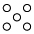

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Target Image


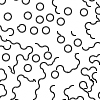

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Target Image


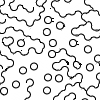

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Target Image


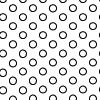

Source Image


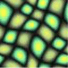

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Target Image


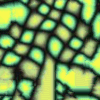

Source Image


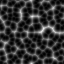

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Target Image


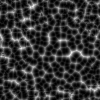

In [59]:
# Texture synthesis on rings
source = cv2.imread('rings.jpg')
window_sizes = [5, 7, 13] 
out_size = [100, 100]

print('Source Image')
cv2_imshow(source)

for w in window_sizes:
  target = synth_texture(source, w, out_size)
  print('Target Image')
  cv2_imshow(target)
  #plt.imshow(target)
  #plt.show()
#plt.imshow(target)

w = 5

# Texture synthesis on colored image
source = cv2.imread('texture.jpg')
print('Source Image')
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)
#plt.imshow(target)
#plt.show()
w = 5
# Don't need to submit this one
source = cv2.imread('my_image.jpg')
print('Source Image')
source = cv2.resize(source, (64, 64))
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)
#plt.imshow(target)

3.2)
The algorithm computational performance improves drastically with window size in terms of improvement in quality of resultant texture, however the time taken to obtain the target image increases with increase in window size. We can notice that for smaller window sizes, the algorithm performs well in certain areas of the image, while the results are quite sub-optimal in certain other areas. 

For a given window size, if we re-run the algorithm with the same starting seed, we will not get the same image each time. This is because although the starting image is the same, the find_matches function returns a list of pixels that satisfy the requirements to be matches to the given texture, and we randomly choose a candidate from this list of pixels. If we were to choose a potential candidate from this list of pixels via a fixed method i.e. by choosing the best match/the match that had the least SSD, then we would obtain the same image each time. This is constant across all window sizes.